# Data

> Über diesen [Link](https://sh333hdm.github.io/jupyterbooktest/intro.html) ist die Ansicht der Projektarbeit als Jupyter Book möglich. 

In [16]:
%matplotlib inline
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats import descriptivestats

sns.set_theme(palette="Pastel2", style="whitegrid") 

## Data Ingestion

In [17]:
# Einlesen der Datei
# func.py: read_data
path = "data\project_data.csv"
df = pd.read_csv(path)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  object 
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  object 
 9   ocean_proximity     20640 non-null  object 
 10  price_category      20640 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 1.7+ MB


Eine Änderung der Datentypen der Variablen *median_house_value*, *housing_median_age*, *ocean_proximity* und *price_category* ist notwendig. 

In [19]:
# func.py: transform_data
#median_house_value -> float
#housing_median_age -> float
#ocean_proximity -> category
#price_category -> category

df['ocean_proximity'] = df['ocean_proximity'].astype("category")
df['price_category'] = df['price_category'].astype("category")

df['median_house_value'] = pd.to_numeric(df['median_house_value'], errors='coerce')
df['housing_median_age'] = pd.to_numeric(df['housing_median_age'], errors='coerce')

Da Anomalien ausschließlich in der ersten Zeile vorkommen, werde diese schon bei der Umwandlung zum Datentyp "numeric" entfernt. Durch setzen des Parameter `errors='coerce'` werden die ungültigen Werte mit NAN aufgefüllt. 

In [20]:
df[(df['median_house_value'] <150000) & (df['price_category'] != 'below')]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
23       -122.27     37.84                52.0         1688           337.0   
26       -122.28     37.85                49.0         1130           244.0   
35       -122.27     37.83                49.0         1215           282.0   
51       -122.27     37.82                43.0         1868           456.0   
52       -122.27     37.82                41.0         3221           853.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0         1665           374.0   
20636    -121.21     39.49                18.0          697           150.0   
20637    -121.22     39.43                17.0         2254           485.0   
20638    -121.32     39.43                18.0         1860           409.0   
20639    -121.24     39.37                16.0         2785           616.0   

       population  households  median_income  median_house_value  \
23            853         325         2.1806             99700.0   
26            607         239         2.4597             93800.0   
35            570         264         1.4861             97200.0   
51           1061         407         1.5045             93800.0   
52           1959         720         1.1108             97500.0   
...           ...         ...            ...                 ...   
20635         845         330         1.5603             78100.0   
20636         356         114         2.5568             77100.0   
20637        1007         433         1.7000             92300.0   
20638         741         349         1.8672             84700.0   
20639        1387         530         2.3886             89400.0   

      ocean_proximity price_category  
23           NEAR BAY          above  
26           NEAR BAY          above  
35           NEAR BAY          above  
51           NEAR BAY          above  
52           NEAR BAY          above  
...               ...            ...  
20635          INLAND          above  
20636          INLAND          above  
20637          INLAND          above  
20638          INLAND          above  
20639          INLAND          above  

[3592 rows x 11 columns]

Die Variable  *price_category* ist nicht korrekt auf den *median_house_value* gemappt. Aus diesem Grund wird die Spalte *price_category* zur Korrektur angepasst. 

In [21]:
# func.py: transform_data
df['price_category'] = np.where(df['median_house_value'] > 150000, 'above', 'below')
df['price_category'] = df['price_category'].astype("category")

In [22]:
df[(df['median_house_value'] <150000) & (df['price_category'] != 'below')]

Empty DataFrame
Columns: [longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value, ocean_proximity, price_category]
Index: []

## Data Spliting

Die vorliegenden Daten werden in Test- und Trainingsdaten aufgespaltet. 


In [23]:
# func.py: split_data
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

## Clean Data

In [24]:
train_dataset.isnull().sum()

longitude               0
latitude                0
housing_median_age      1
total_rooms             0
total_bedrooms        160
population              0
households              0
median_income           0
median_house_value      1
ocean_proximity         0
price_category          0
dtype: int64

<AxesSubplot:>

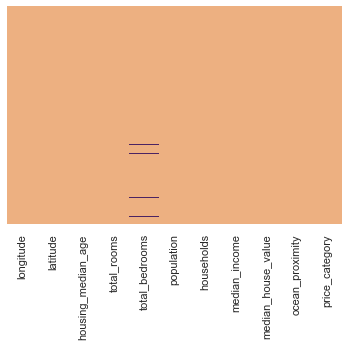

In [25]:
sns.heatmap(train_dataset.isnull(),yticklabels=False,cbar=False, cmap='flare')

Der Wert NAN tritt insgesamt 162 mal auf. Auf Grund der geringen Anzahl werden die Datensätze entfernt.  

In [26]:
#func.py: fill_missingdata
median_total_bedrooms = train_dataset["total_bedrooms"].median()
train_dataset.dropna(inplace=True)
train_dataset.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
price_category        0
dtype: int64

Für die Modelle mit scikit-learn wird der `SimpleImputer` genutzt. Die numerischen NAN-Werte, werden dafür mit dem Median aufgefüllt. 

## Analyse Data

### Geographische Daten- Mapping

Im ersten Schritt wird der *median_house_value* auf Kartendarstellungen visualisert. 

In [27]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px


fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = df['longitude'],
        lat = df['latitude'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'AgSunset',
            cmin = 0,
            color = df['median_house_value'],
            cmax = df['median_house_value'].max(),
            colorbar_title="Median house value"
        )))

fig.update_layout(
        title = 'Map Median House Value',
        geo_scope='usa',
    )
fig.show()

Darstellung Github Pages: [Link](https://sh333hdm.github.io/jupyterbooktest/map1.html)

In [28]:
import plotly.io as pio

pio.write_html(fig, file='map1.html', auto_open=True)

In [29]:

import plotly.express as px

fig = px.scatter_mapbox(train_dataset, lat="latitude", lon="longitude", size= "median_house_value",color="median_house_value",color_continuous_scale = 'Sunset',zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [30]:
pio.write_html(fig, file='map2.html', auto_open=True)

Darstellung Github Pages: [Link](https://sh333hdm.github.io/jupyterbooktest/map2.html)

### Geographische Variablen - Scatterplot

Um die Beziehung der Variablen *Longitude/Latitude* zu *median_house_value* und *ocean_proximity* besser nachvollziehen zu können, werden diese Werte im zweiten Schritt als Streudiagramm analysiert. 

In [31]:
plt.rcParams['figure.figsize'] = [16, 16]

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

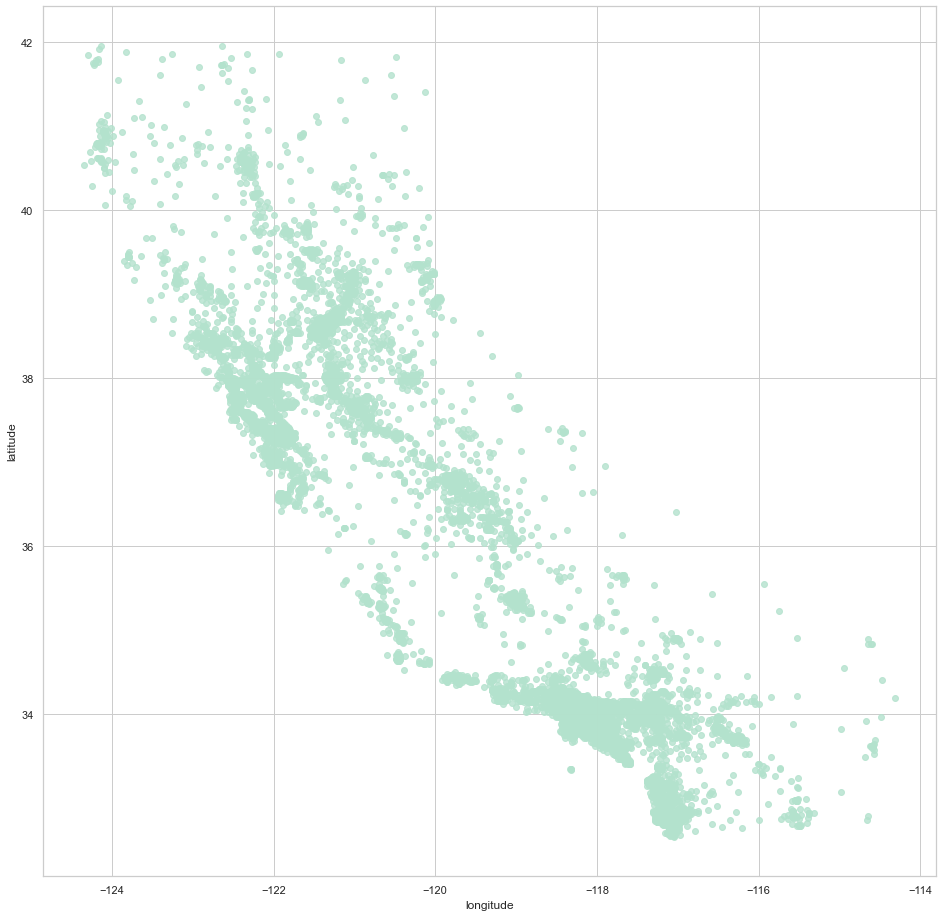

In [32]:
sns.regplot(data = train_dataset, x="longitude", y="latitude",  fit_reg=False)

Im Scatterplot ist der US-Bundesstaat Kalifornien mit den Ballungsgebieten San Francisco und Los Angeles abgebildet. 

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

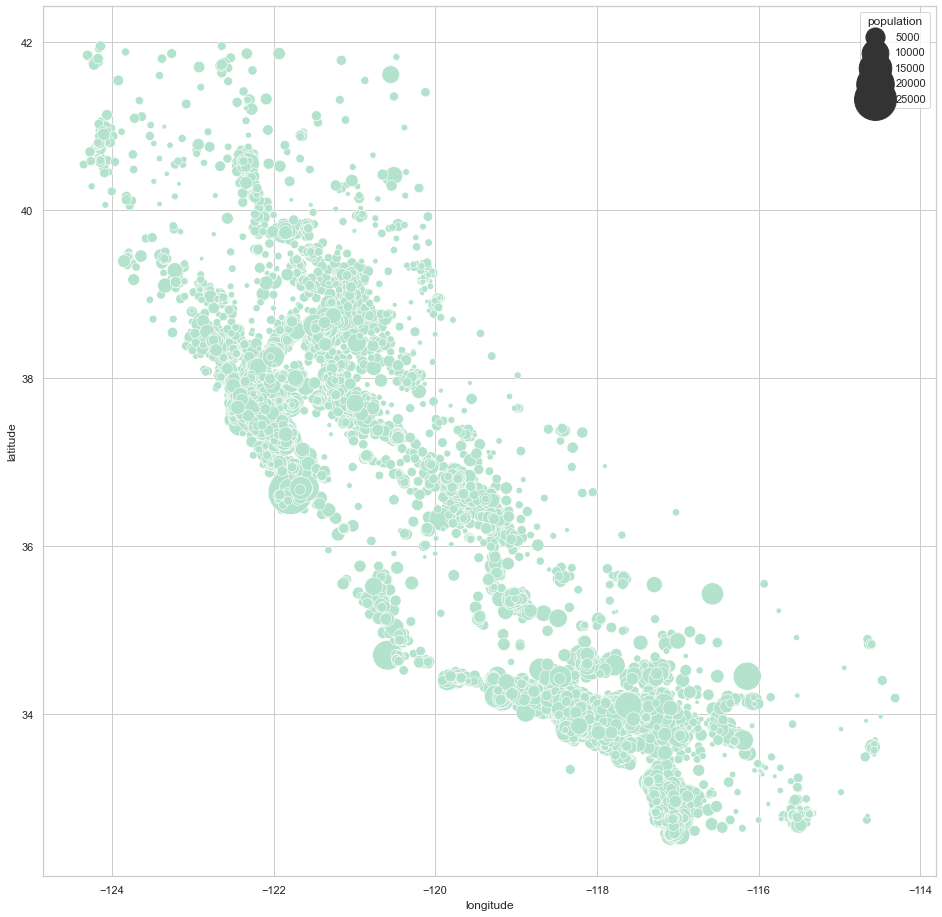

In [33]:
sns.scatterplot(data=train_dataset, x="longitude", y="latitude", size="population", legend=True, sizes=(20, 2000))

Die Größe der Populationszentren bestätigt die Annahme, dass es sich um Ballungsgebiete handelt. 

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

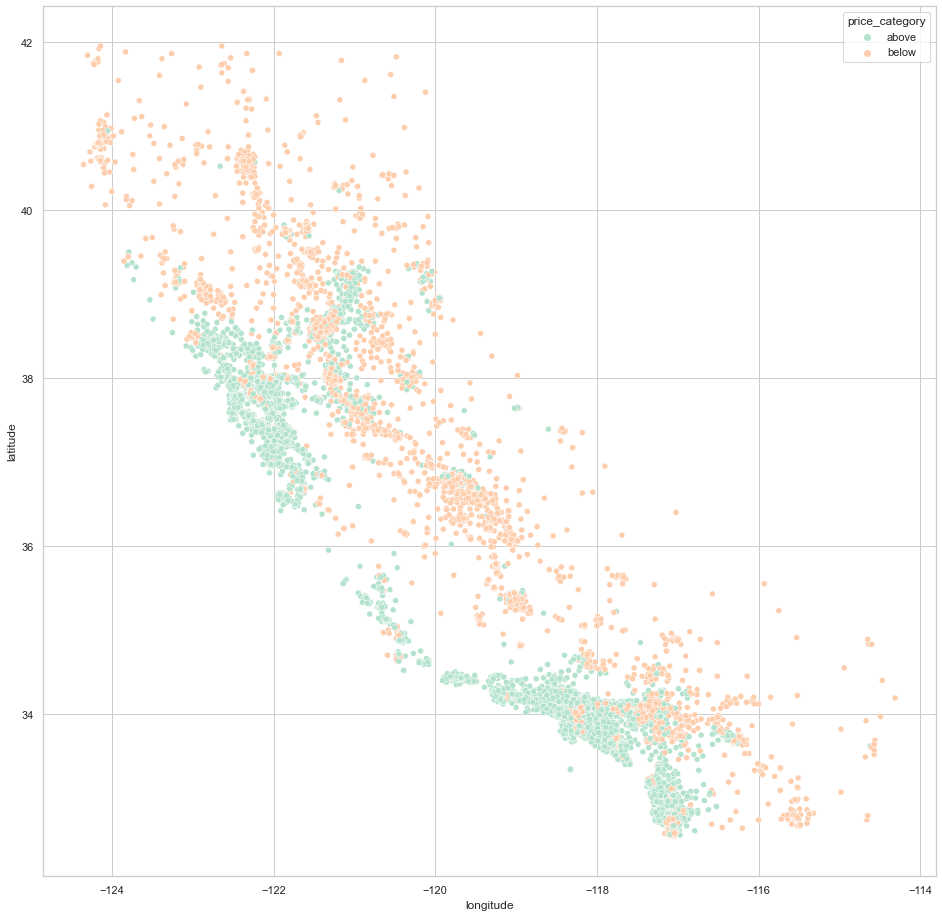

In [34]:

sns.scatterplot(data = train_dataset, x="longitude", y="latitude",  hue = "price_category")

Die Hervorhebung der Ausprägungen der kategorialen Variable *price_category* lässt vermuten, dass es einen Zusammenhang zwischen der Lage und *median_house_value*/*price_category* gibt. 

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

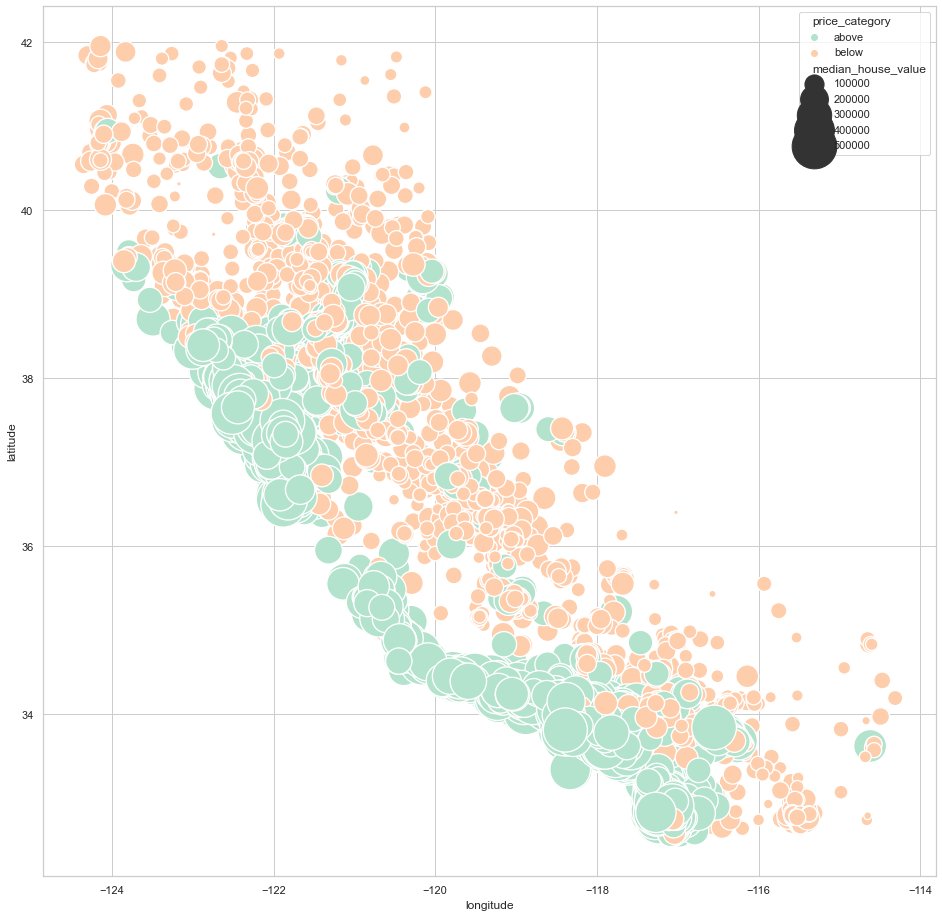

In [35]:
sns.scatterplot(data=train_dataset, x="longitude", y="latitude", size="median_house_value", hue="price_category", legend=True, sizes=(20, 2000))


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

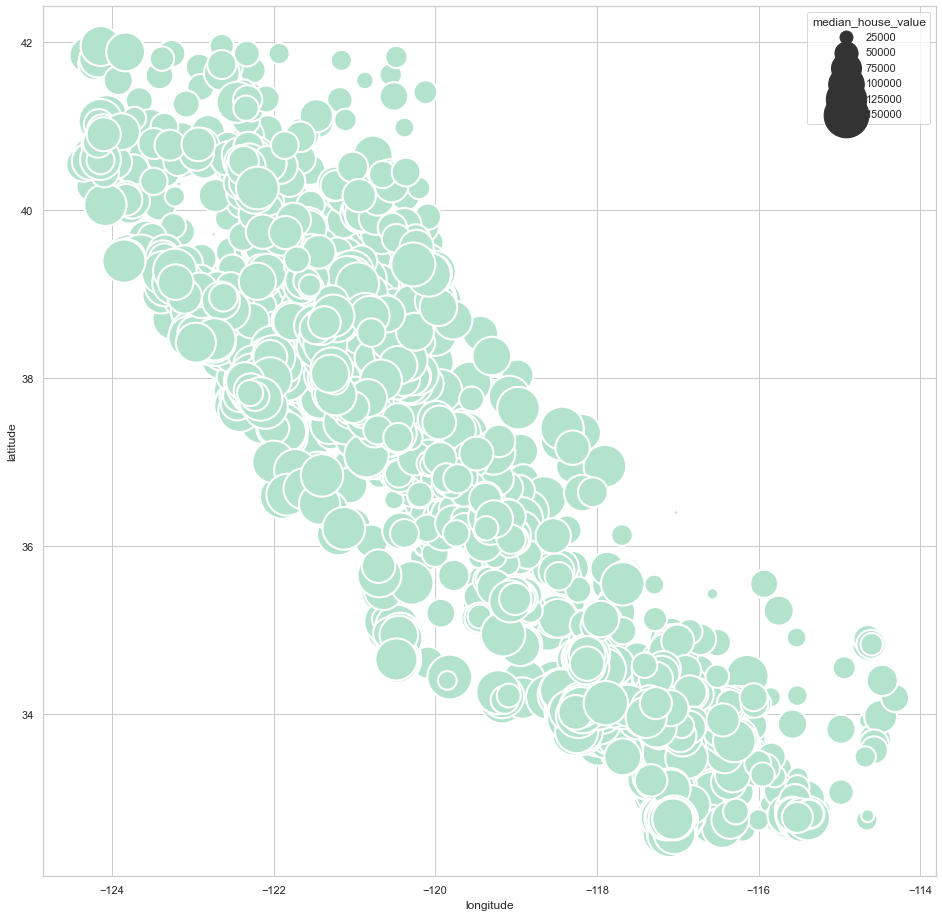

In [36]:
df_below = train_dataset[train_dataset['price_category'] == 'below']
sns.scatterplot(data=df_below, x="longitude", y="latitude", size="median_house_value", legend=True, sizes=(20, 2000))

* Die Distrikte mit einem *median_house_value* von unter 150 Tsd. sind über den gesamten Staat Kalifornien verteilt.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

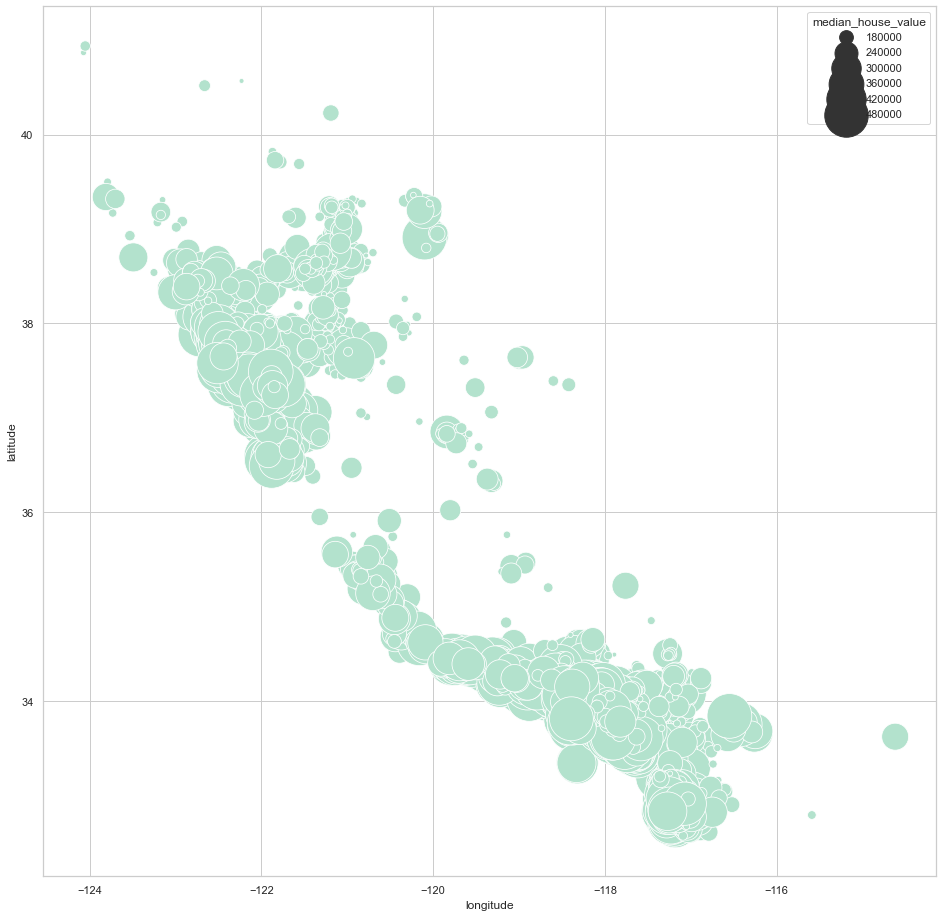

In [37]:
df_above = train_dataset[train_dataset['price_category'] == 'above']
sns.scatterplot(data=df_above, x="longitude", y="latitude", size="median_house_value", legend=True, sizes=(20, 2000))


* Die Distrikte  mit einem *median_house_value* von über 150 Tsd. scheinen sich auf bestimmte Flächen zu konzentrieren. 
* Aus diesem Grund kann es sinnvoll sein *longitude*/ *latitude* mit in der Erstellung der Modelle zu berücksichtigen. Beim Feauture Engineering sollte dafür ein geeigneter Weg gefunden werden. 

### Numerische Variablen -Übersicht

In [38]:
train_dataset.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  16351.000000  16351.000000        16351.000000  16351.000000   
mean    -119.561152     35.627474           28.624916   2625.422971   
std        1.997694      2.132312           12.581105   2151.964716   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.775000     33.930000           18.000000   1450.000000   
50%     -118.490000     34.260000           29.000000   2122.000000   
75%     -118.010000     37.710000           37.000000   3133.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    16351.000000  16351.000000  16351.000000   16351.000000   
mean       535.917008   1420.381934    497.484252       3.869469   
std        416.463980   1100.755736    377.235553       1.911662   
min          1.000000      3.000000      1.000000       0.499900   
25%        295.000000    787.000000    280.000000       2.556200   
50%        434.000000   1163.000000    408.000000       3.528800   
75%        644.000000   1724.000000    602.000000       4.744000   
max       6445.000000  28566.000000   6082.000000      15.000100   

       median_house_value  
count        16351.000000  
mean        206852.044034  
std         115735.297652  
min          14999.000000  
25%         119400.000000  
50%         179400.000000  
75%         265000.000000  
max         500001.000000

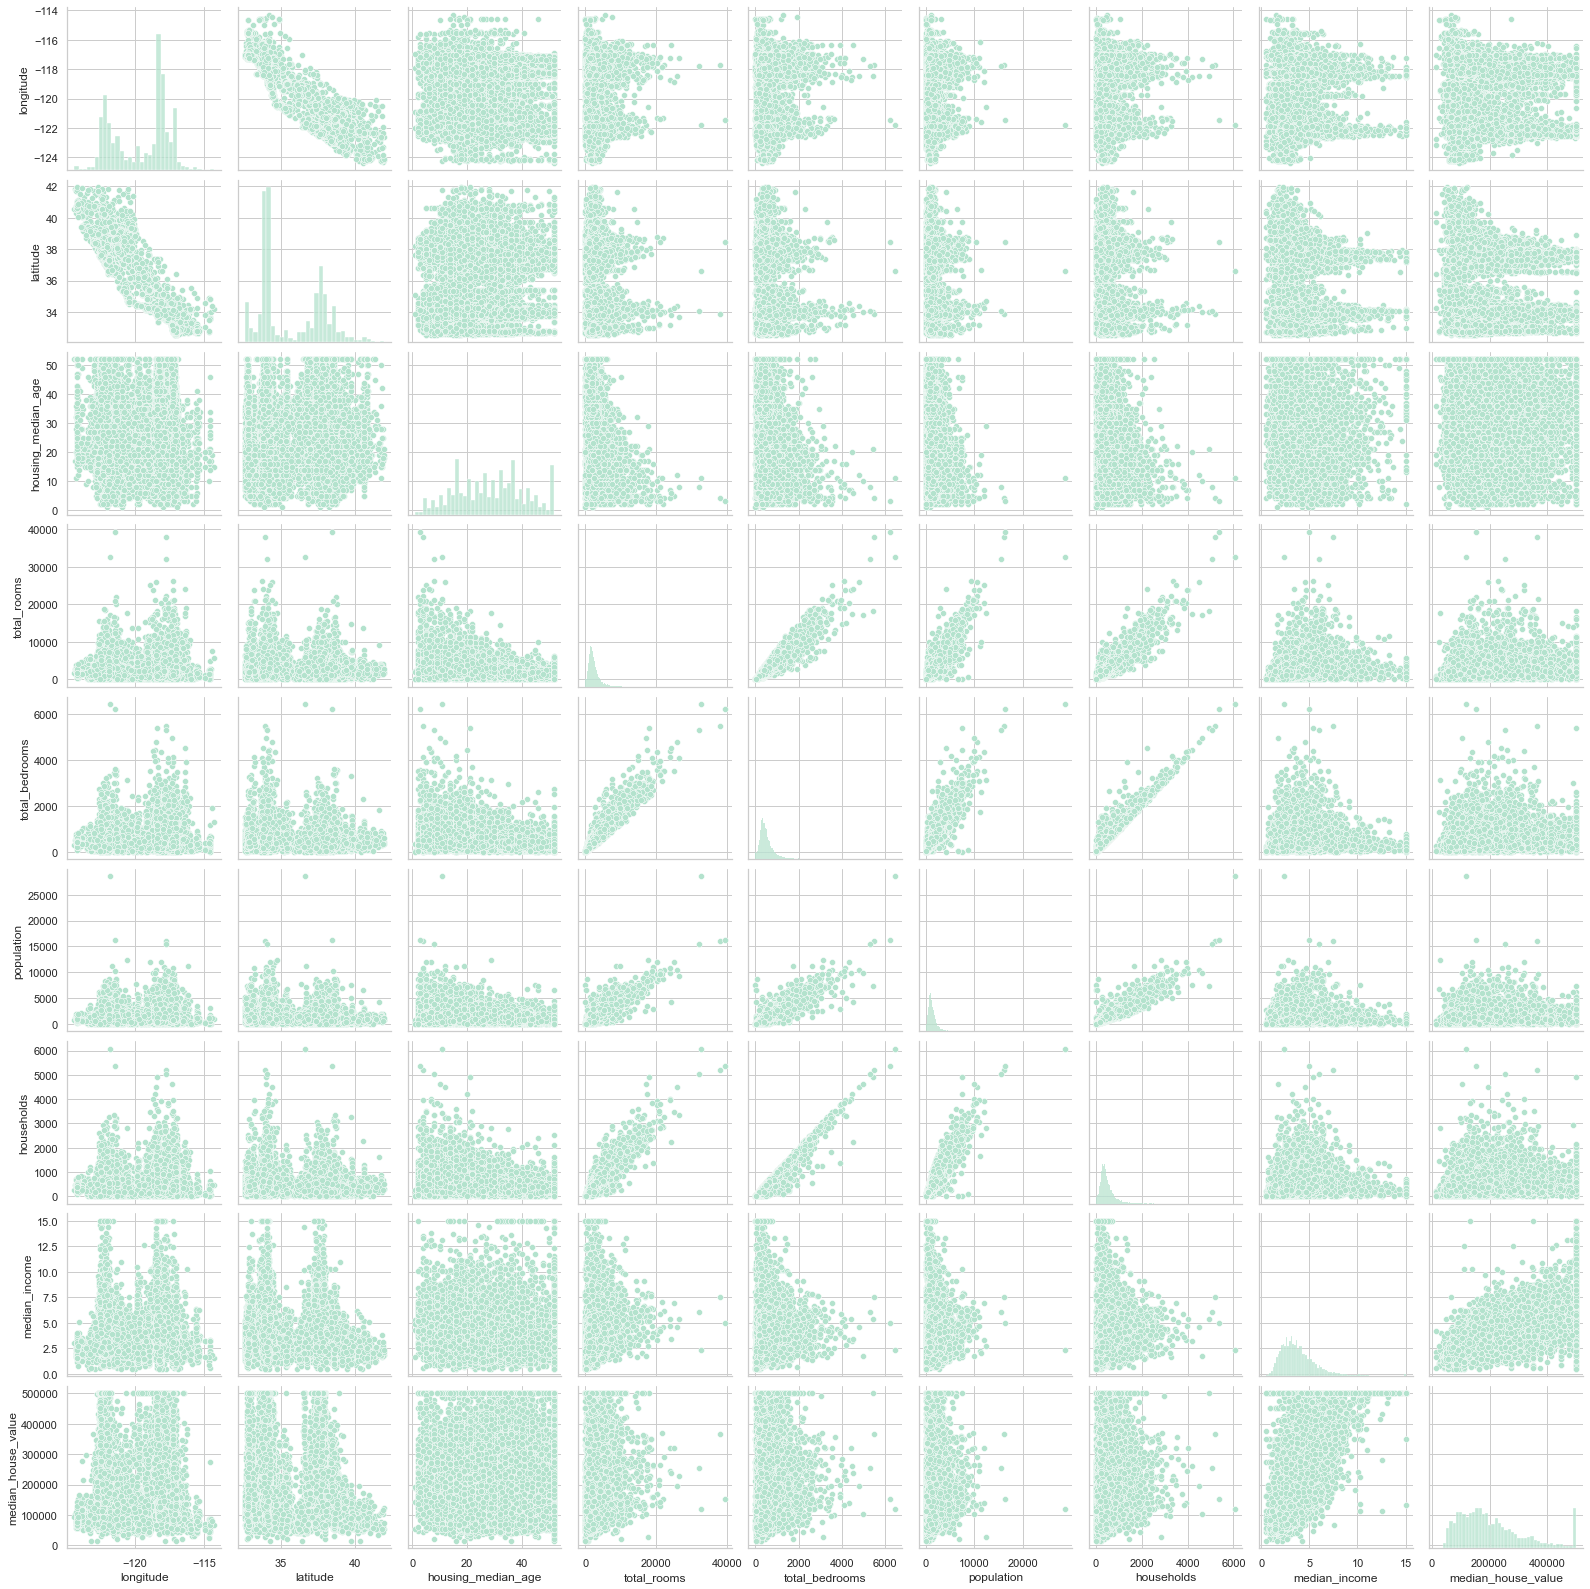

In [39]:
sns.pairplot(train_dataset)

Folgende erste Erkenntnisse können aus den `pairplot` geschlossen werden: 
* *median_house_value* hat die deutlichste Beziehung mit *median_income*. Die Beziehung ist positiv. 
* Zu den anderen numerischen Größen (in Bezug auf *median_house_value*) ist im `pairplot` kein eindeutiger Zusammenhang identifizierbar. 
* Die Variablen *households*, *population*, *total_bedrooms* und *total_rooms* scheinen untereinander in Beziehung (positiv) zu stehen. 

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

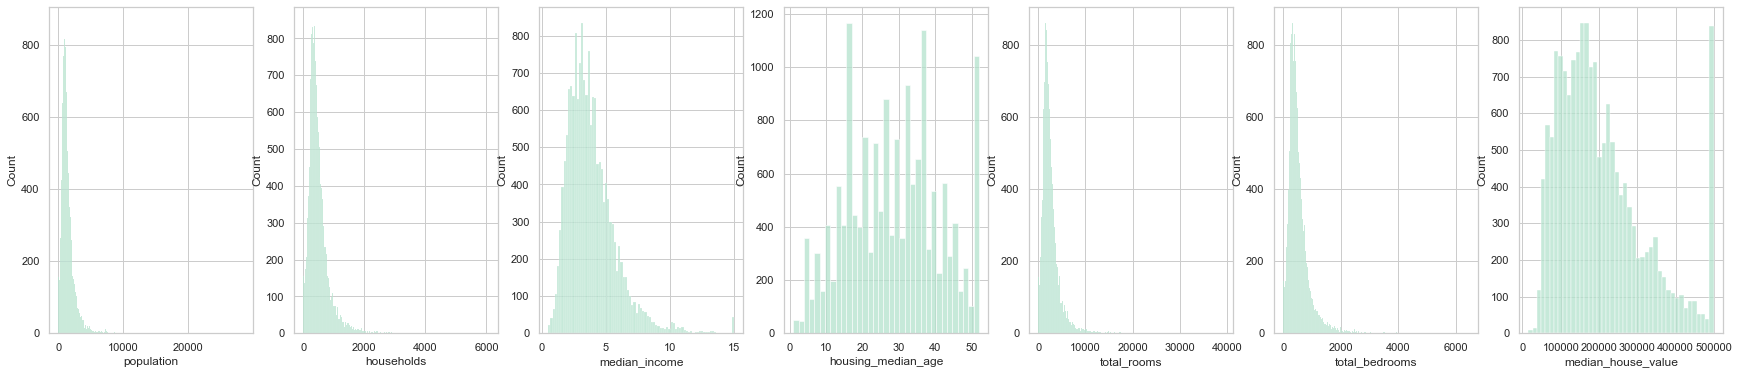

In [40]:
fig, axs = plt.subplots(1, 7, figsize=(30,6))
sns.histplot(data=train_dataset, x="population", ax=axs[0])
sns.histplot(data=train_dataset, x="households", ax=axs[1])
sns.histplot(data=train_dataset, x="median_income", ax=axs[2])
sns.histplot(data=train_dataset, x="housing_median_age", ax=axs[3])
sns.histplot(data=train_dataset, x="total_rooms", ax=axs[4])
sns.histplot(data=train_dataset, x="total_bedrooms", ax=axs[5])
sns.histplot(data=train_dataset, x="median_house_value", ax=axs[6])

Folgende Erkenntnisse lassen sich aus dem Diagrammen ableiten: 

* Die Verteilungen von *population, households, total_rooms, total_bedrooms, median_income, median_house_value* sind linksschief. 
* Auffällig sind Ausschläge am Maximum-Punkt bestimmter Variablen: 
  * Peak bei *median_house_value* 50000 
  * Peak bei *house_median_age* 50 Jahre
  * Peak bei *median_income* bei 15,0 
  * Schlussfolgerung: Werte scheinen eine obere Grenze zu haben. Alle Distrikte oberhalb der jeweiligen Grenze scheinen zu einem Datenpunkt zusammengefasst zu sein. 
  * Für die Anwendung eines linearen Modells kann es sinnvoll sein diese Werte zu entfernen. 

In [41]:
#Mögliche Funktion
#id_income = train_dataset[train_dataset['median_income'] >= 15.0].index
#id_housing = train_dataset[train_dataset['housing_median_age'] >= 52.0].index
#train_dataset.drop(index=id_income, inplace =True)
#train_dataset.drop(index=id_housing, inplace =True)

### Numerische Variablen -Korrelation 

In [42]:
#Korellation untersuchen 
train_dataset_corr = train_dataset.drop(columns=['longitude', 'latitude'])
corr_matrix = train_dataset_corr.corr()
corr_matrix

housing_median_age  total_rooms  total_bedrooms  \
housing_median_age            1.000000    -0.357963       -0.314801   
total_rooms                  -0.357963     1.000000        0.928971   
total_bedrooms               -0.314801     0.928971        1.000000   
population                   -0.293364     0.858441        0.879512   
households                   -0.295917     0.916585        0.978452   
median_income                -0.116910     0.197395       -0.009969   
median_house_value            0.107851     0.131556        0.048469   

                    population  households  median_income  median_house_value  
housing_median_age   -0.293364   -0.295917      -0.116910            0.107851  
total_rooms           0.858441    0.916585       0.197395            0.131556  
total_bedrooms        0.879512    0.978452      -0.009969            0.048469  
population            1.000000    0.910627       0.002822           -0.028441  
households            0.910627    1.000000       0.010884            0.064225  
median_income         0.002822    0.010884       1.000000            0.686126  
median_house_value   -0.028441    0.064225       0.686126            1.000000

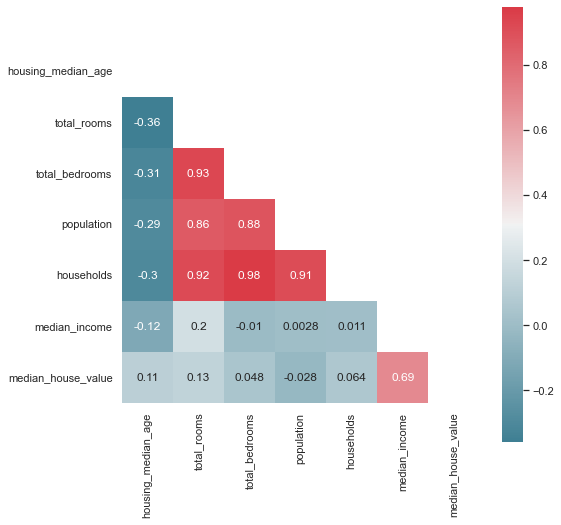

In [43]:
# Simple heatmap
plt.rcParams['figure.figsize'] = [8, 8]
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

heatmap = sns.heatmap(corr_matrix, mask = mask, square = True, cmap= cmap,  annot=True)

* Wie nach Auswertung des `pairplots` vermutet, bestätigt sich, dass *median_house_value* mit *median_income* am stärksten korreliert. 
* Die Korrelation zu den anderen Variablen ist gering. 
* Es besteht eine sehr hohe Korrelation zwischen *total_rooms, total_bedrooms*, *households* und *population*. Bei gemeinsamer Verwendung in einem Modell deutet dies auf Multikollinearität hin. Dies sollte vermieden werden.

### Numerische Variablen- Deskriptive Statistik

In [44]:
round(train_dataset.describe(),2).transpose()

count       mean        std       min        25%  \
longitude           16351.0    -119.56       2.00   -124.35    -121.78   
latitude            16351.0      35.63       2.13     32.54      33.93   
housing_median_age  16351.0      28.62      12.58      1.00      18.00   
total_rooms         16351.0    2625.42    2151.96      2.00    1450.00   
total_bedrooms      16351.0     535.92     416.46      1.00     295.00   
population          16351.0    1420.38    1100.76      3.00     787.00   
households          16351.0     497.48     377.24      1.00     280.00   
median_income       16351.0       3.87       1.91      0.50       2.56   
median_house_value  16351.0  206852.04  115735.30  14999.00  119400.00   

                          50%        75%        max  
longitude             -118.49    -118.01    -114.31  
latitude                34.26      37.71      41.95  
housing_median_age      29.00      37.00      52.00  
total_rooms           2122.00    3133.00   39320.00  
total_bedrooms         434.00     644.00    6445.00  
population            1163.00    1724.00   28566.00  
households             408.00     602.00    6082.00  
median_income            3.53       4.74      15.00  
median_house_value  179400.00  265000.00  500001.00

Die deskriptive Statistik der numerischen Variablen erfolgt auf Grundlage der Lagemaße Median (median), Mittelwert (mean) und Modus (mode), sowie der Streuungsmaße Standardabweichung (std), Spannweite (range) und des Interquartilabstand. 

In [45]:
descriptivestats.describe(data = train_dataset[['median_house_value', 'median_income', 'housing_median_age', 'population', 'households']],stats = ["mean", "median", "mode", "std", "range", "min", "max", "percentiles","iqr"], categorical= False).transpose()

mean       median         mode  mode_freq  \
median_house_value  206852.044034  179400.0000  500001.0000   0.047459   
median_income            3.869469       3.5288      15.0001   0.002569   
housing_median_age      28.624916      29.0000      52.0000   0.061281   
population            1420.381934    1163.0000     891.0000   0.001468   
households             497.484252     408.0000     306.0000   0.002936   

                              std        range         min          max  \
median_house_value  115735.297652  485002.0000  14999.0000  500001.0000   
median_income            1.911662      14.5002      0.4999      15.0001   
housing_median_age      12.581105      51.0000      1.0000      52.0000   
population            1100.755736   28563.0000      3.0000   28566.0000   
households             377.235553    6081.0000      1.0000    6082.0000   

                            iqr          1%          5%         10%  \
median_house_value  145600.0000  50000.0000  65900.0000  82000.0000   
median_income            2.1878      1.0714      1.6003      1.8972   
housing_median_age      19.0000      4.0000      8.0000     12.0000   
population             937.0000     83.0000    347.0000    513.0000   
households             322.0000     27.5000    125.0000    185.0000   

                            25%          50%         75%          90%  \
median_house_value  119400.0000  179400.0000  265000.000  377300.0000   
median_income            2.5562       3.5288       4.744       6.1724   
housing_median_age      18.0000      29.0000      37.000      46.0000   
population             787.0000    1163.0000    1724.000    2564.0000   
households             280.0000     408.0000     602.000     884.0000   

                            95%           99%  
median_house_value  493650.0000  500001.00000  
median_income            7.3341      10.60835  
housing_median_age      52.0000      52.00000  
population            3288.5000    5752.00000  
households            1151.0000    1954.00000

* Die obere Grenze der Werte *housing_median_age, median_income* und *median_house_value* wird auch in der deskriptiven Statistik deutlich. Der Modus ist genauso hoch wieder der Maximalwert.
* Die weiteren ermittelten Größen werden in die EDA einbezogen. 

### Numerische Variabeln- EDA

**EDA Median Income**

<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>

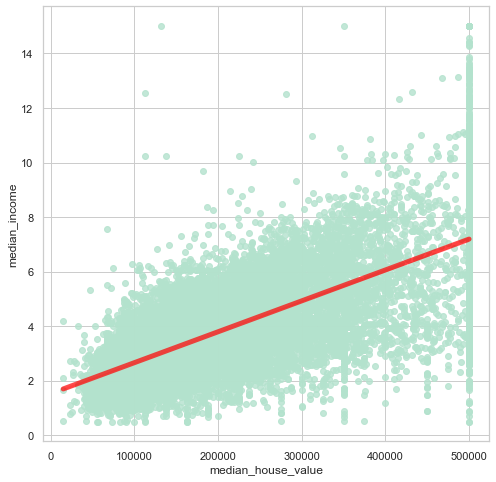

In [46]:
sns.regplot(x=train_dataset["median_house_value"], y=train_dataset["median_income"], line_kws={"color":"r","alpha":0.7,"lw":5})

* Die positive Beziehung wird durch das Streuungsdiagramm visuell verdeutlicht. 


<AxesSubplot:ylabel='median_income'>

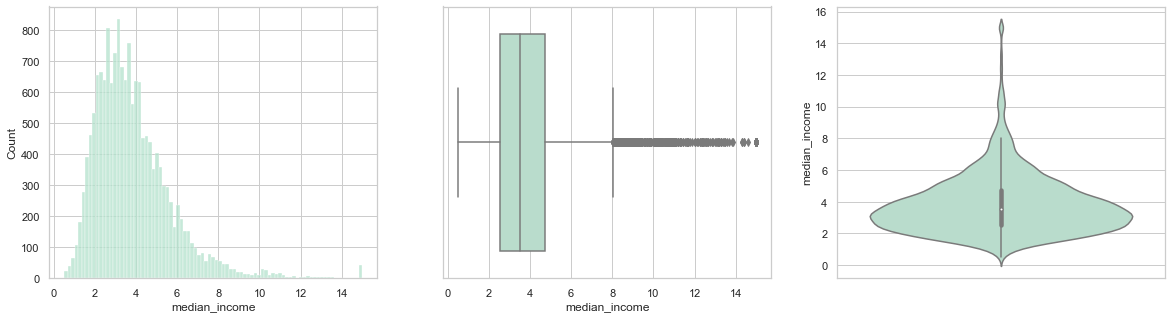

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
sns.histplot(data=train_dataset, x="median_income", ax=axs[0])
sns.boxplot(data=train_dataset, x="median_income",ax=axs[1])
sns.violinplot(y=train_dataset["median_income"],ax=axs[2])

* Im Boxplot wird deutlich, dass die Interquartilrange im Vergleich zur Spannweite gering ist. 
* Da im Boxplot Ausreißer über den Interquartilsabstands (>1,5) definiert  werden, ist eine Vielzahl an Ausreißer zu erkennen. 
* Aus diesem Grund ist die Verteilung zusätzlich mit einem Violin-Plot dargstellt. 

<AxesSubplot:xlabel='median_income', ylabel='Density'>

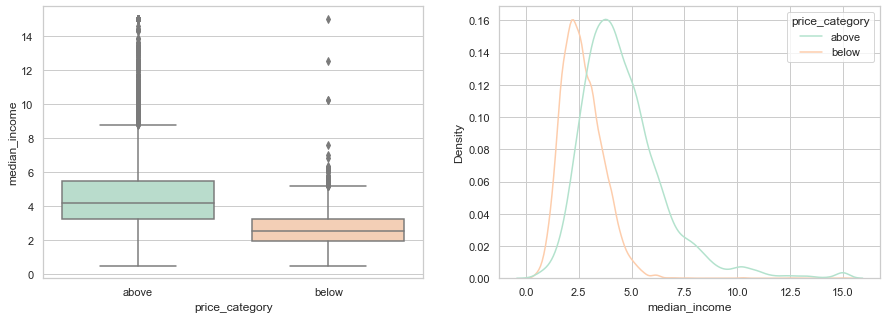

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot( x=train_dataset["price_category"], y=train_dataset["median_income"], ax=axs[0])
sns.kdeplot(data=train_dataset, x="median_income", hue="price_category",ax=axs[1])

* Sowohl in der Boxplot, wie auch in der Densitiy-Darstellung, wird die unterschiedliche Verteilung des *median_incomes* deutlich. 
* Der Median liegt bei above-Distrikten bei einem mittleren Einkommen von 45 Tsd. USD und bei below-Distrikten bei 26 Tsd. USD. 

> Das Feature *median_income* sollte in den statistischen Modell (Klassifikation und Regression) mit berücksichtigt werden.

**EDA housing_age**

<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>

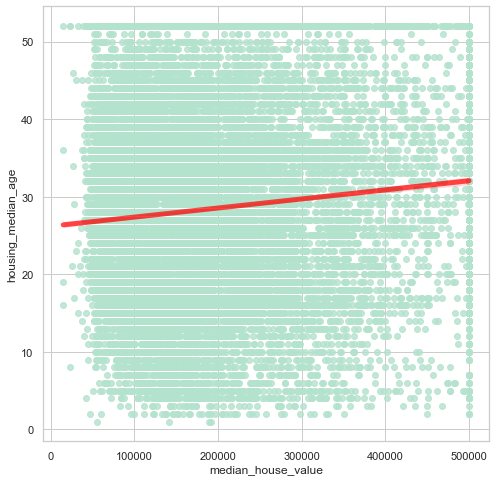

In [49]:
sns.regplot(x=train_dataset["median_house_value"], y=train_dataset["housing_median_age"], line_kws={"color":"r","alpha":0.7,"lw":5})

* Im Streudiagramm ist keine deutliche Beziehung zwischen *housing_median_age* und *median_house_value* erkennbar. 
* Vielmehr scheint das mittlere Immobilienalter über die gesamte Fläche zu streuen. 


C:\Users\sophi\anaconda3\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.25 for `bw_method`, but please see the docs for the new parameters and update your code.



<AxesSubplot:ylabel='housing_median_age'>

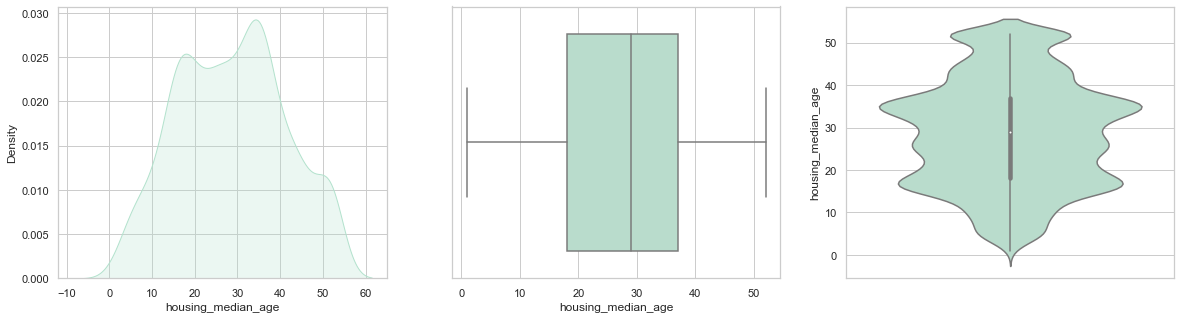

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
sns.kdeplot(data=train_dataset, x="housing_median_age", shade=True, bw=0.25, ax=axs[0])
sns.boxplot(data=train_dataset, x="housing_median_age",ax=axs[1])
sns.violinplot(y=train_dataset["housing_median_age"],ax=axs[2])

Um weitere Visualisierungen der Beziehung zwischen *housing_median_age* und *median_house_value* darzustellen, wird aus Erstem eine kategoriale Variable erstellt. 

In [1]:
train_dataset['housingage_cat'] = '00'
train_dataset['housingage_cat'][train_dataset['housing_median_age'] <18] = '25'
train_dataset['housingage_cat'][(train_dataset['housing_median_age'] >=18) & (train_dataset['housing_median_age'] <=29)] = '50'
train_dataset['housingage_cat'][(train_dataset['housing_median_age'] >29) & (train_dataset['housing_median_age'] <=37)] = '75'
train_dataset['housingage_cat'][(train_dataset['housing_median_age'] >37)] = '100'

NameError: name 'train_dataset' is not defined

In [52]:
train_dataset

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
14740    -117.05     32.58                22.0         2101           399.0   
10101    -117.97     33.92                32.0         2620           398.0   
20566    -121.84     38.65                29.0         3167           548.0   
2670     -115.60     33.20                37.0          709           187.0   
15709    -122.43     37.79                25.0         1637           394.0   
...          ...       ...                 ...          ...             ...   
7616     -118.22     33.86                16.0         8732          1489.0   
8767     -118.39     33.81                35.0         1008           165.0   
16388    -121.30     38.05                52.0          122            26.0   
19949    -119.37     36.21                35.0         2228           476.0   
10078    -120.27     39.35                11.0         2520           401.0   

       population  households  median_income  median_house_value  \
14740        1551         371         4.1518            136900.0   
10101        1296         429         5.7796            241300.0   
20566        1554         534         4.3487            200700.0   
2670          390         142         2.4511             72500.0   
15709         649         379         5.0049            460000.0   
...           ...         ...            ...                 ...   
7616         3944        1493         5.1948            203500.0   
8767          391         167         3.7778            487500.0   
16388          62          25         1.1500            112500.0   
19949        1567         449         1.4455             54100.0   
10078         397         165         4.6650            145600.0   

      ocean_proximity price_category housingage_cat  
14740      NEAR OCEAN          below             50  
10101       <1H OCEAN          above             75  
20566          INLAND          above             50  
2670           INLAND          below             75  
15709        NEAR BAY          above             50  
...               ...            ...            ...  
7616        <1H OCEAN          above             25  
8767       NEAR OCEAN          above             75  
16388          INLAND          below            100  
19949          INLAND          below             75  
10078          INLAND          below             25  

[16351 rows x 12 columns]

<AxesSubplot:xlabel='housingage_cat', ylabel='median_house_value'>

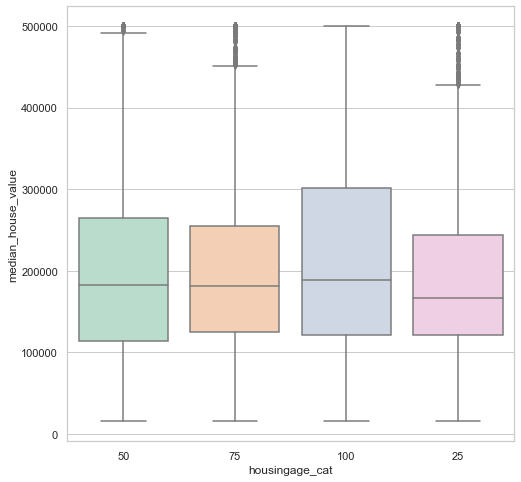

In [53]:
sns.boxplot( x=train_dataset["housingage_cat"], y=train_dataset["median_house_value"])

In [54]:
train_dataset.drop(columns= 'housingage_cat', inplace = True)

Auch in dieser Darstellung ist keine eindeutige Beziehung erkennbar und die generierte Variable wird wieder entfernt. 

<AxesSubplot:xlabel='housing_median_age', ylabel='Density'>

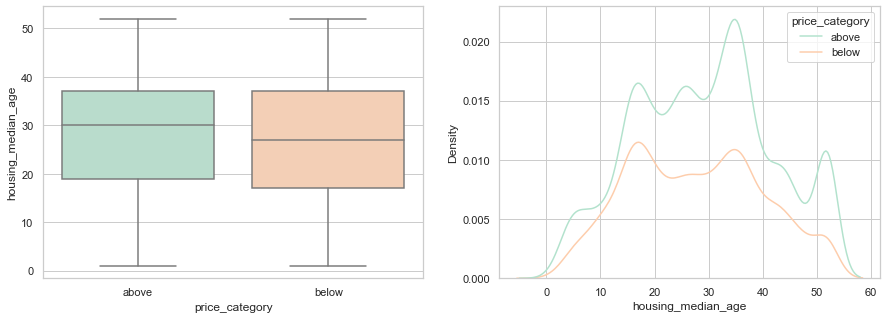

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot( x=train_dataset["price_category"], y=train_dataset["housing_median_age"], ax=axs[0])
sns.kdeplot(data=train_dataset, x="housing_median_age", hue="price_category",ax=axs[1])

Ebenfalls bei der Betrachtung der Beziehung zwischen *price_category* und *housing_median_age*, ist kein eindeutiger Zusammenhang erkennbar. 

> Bei *housing_median_age* ist keine eindeutige Beziehung zu *median_house_value* oder *price_category* erkennbar.
> Der positive Effekt auf das Modell wird als gering eingeschätzt. 

### Kategoriale Variablen- Deskriptive Statistik

In [56]:
from statsmodels.stats import descriptivestats
descriptivestats.describe(data = train_dataset, categorical= True).ocean_proximity.dropna()

nobs             16351
missing              0
distinct             5
top_1        <1H OCEAN
top_2           INLAND
top_3       NEAR OCEAN
top_4         NEAR BAY
top_5           ISLAND
freq_1        0.441869
freq_2        0.319736
freq_3        0.128861
freq_4         0.10929
freq_5        0.000245
Name: ocean_proximity, dtype: object

In [57]:
train_dataset.ocean_proximity[train_dataset['ocean_proximity'] == 'ISLAND'].count()

4

Die kategoriale Variable *ocean_proximity* hat fünf Ausprägung: "<1H OCEAN", "INLAND", "NEAR BAY", "NEAR OCEAN" und "ISLAND". 

Durch die Analyse der Verteilung wird deutlich, dass die Ausprägungen <1H OCEAN (44%)und Inland (32%) am häufigsten vorkommen. Distrikte "NEAR BAY" und "NEAR OCEAN" kommen seltenere vor. Sehr selten liegen Distrikte auf Inseln. In dem Trainingsdatensatz sind es nur vier 4 Distrikte.

### Kategoriale Variable- EDA

Im folgenden wird die Variable "ocean_proximity" detailiert betrachtet. 

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

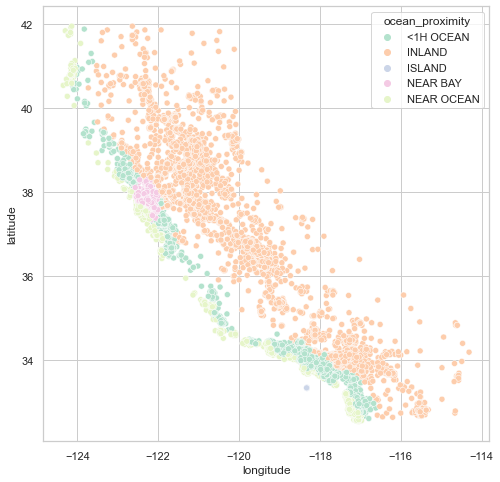

In [58]:
sns.scatterplot(data = train_dataset, x="longitude", y="latitude",  hue = "ocean_proximity")

Zum Nachvollziehen der kategorialen Variable *ocean_proximity* ist diese im Scatterplot durch `hue` dargestellt. 

<AxesSubplot:xlabel='ocean_proximity', ylabel='Count'>

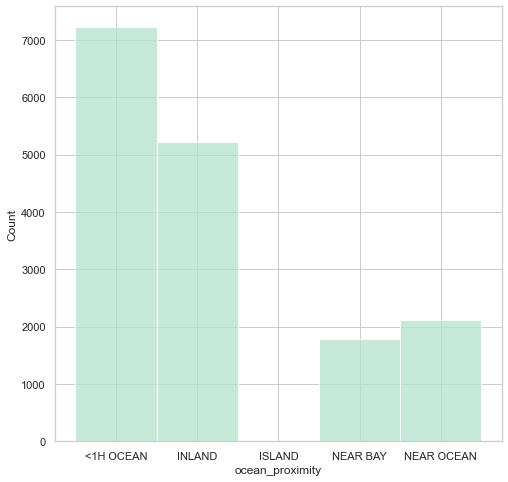

In [59]:
sns.histplot(data=train_dataset, x="ocean_proximity")

* Die meisten Distrikte liegen weniger als eine Stunde vom Ozean weg.
* Sehr wenige Distrikte befinden sich auf Insel.


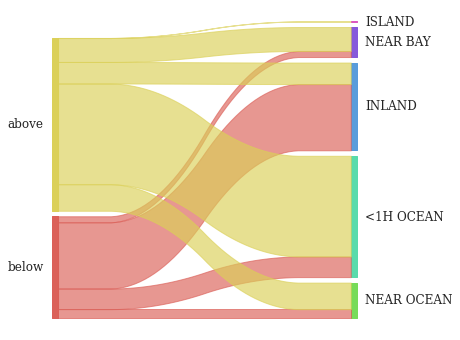

In [60]:
from pySankey.sankey import sankey
sankey(train_dataset["price_category"], train_dataset["ocean_proximity"], aspect=20, fontsize=12)

* Die meisten Distrikte, die zur Preiskategegorie "below" gehören, liegen im Inland. 
* Die meisten Distrikte, die zur Preiskategorie "above" gehören, liegen weniger als eine Stunde vom Ozean entfernt. 
* Dementsprechend kann es sinnvoll sein, die kategoriale Variable *ocean_proximity* bei der Klassifikation mit einzubeziehen. 

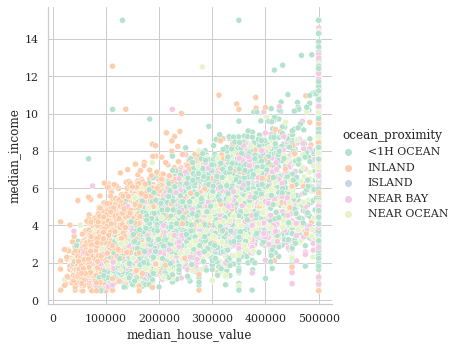

In [61]:
sns.relplot(data = train_dataset, 
            x = "median_house_value",
            y= "median_income", 
            hue = "ocean_proximity")

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

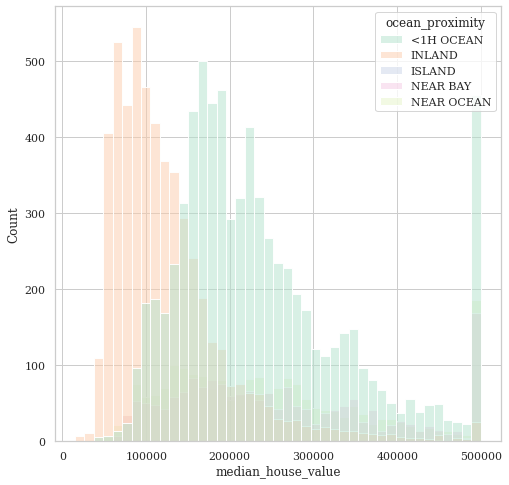

In [62]:
sns.histplot(data = train_dataset, x="median_house_value", hue="ocean_proximity")


* Das Histogramm bestätigt, dass die Nähe zum Ozean Einfluss auf *median_house_value* hat. 
* Bei Distrikten im Inland ist die Verteilung im Vergleich zu "<1h Ocean" linksverschoben. 
* Da die Variable *ocean_proximity* fünf Ausprägungen hat, ist es sinnvoll sich die Verteilung in separaten Plots anzuschauen.

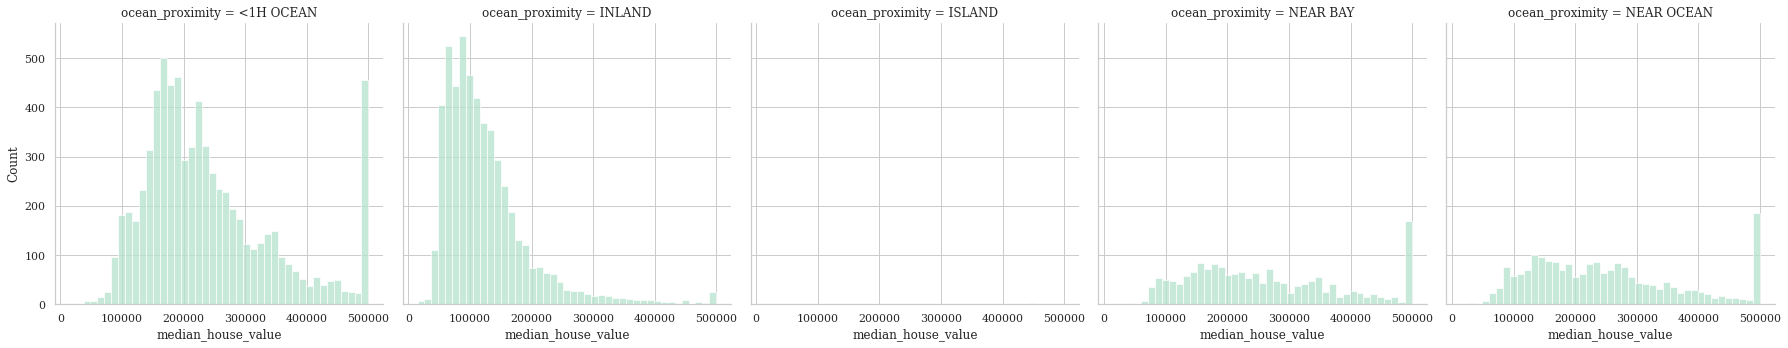

In [63]:
sns.displot(train_dataset, x="median_house_value", col="ocean_proximity")

* Die unterscheidlichen Verteilungen scheinen die Vermutung zu bestätigen. 


> Die Variable *ocean_proximity* sollte in dem statistischen  Modell (Klassifikation und Regression) mit berücksichtigt werden.

## Feature Engineering 

### Feature extraction 

Wie in der EDA dargestellt, besitzen die Variablen *total_rooms, total_bedrooms, population* und *households* eine hohe Korrelation untereinander und eine niedrige Korrelation zum *median_house_value*. Für das Modell wird versucht aus der Kombination der Variablen neue Merkmale zu generieren, welche eine höhere Korrelation zu der zu bestimmenden Größe aufweisen.  

In [64]:
train_dataset['households_population'] = train_dataset['households']/train_dataset['population']
train_dataset['total_rooms_households'] = train_dataset['total_rooms']/train_dataset['households']
train_dataset['total_rooms_total_bedrooms'] = train_dataset['total_rooms']/train_dataset['total_bedrooms']

In [65]:
corr = train_dataset.corr()
corr["median_house_value"].sort_values(ascending=False)

median_house_value            1.000000
median_income                 0.686126
total_rooms_total_bedrooms    0.381188
households_population         0.266170
total_rooms_households        0.138478
total_rooms                   0.131556
housing_median_age            0.107851
households                    0.064225
total_bedrooms                0.048469
population                   -0.028441
longitude                    -0.044385
latitude                     -0.146228
Name: median_house_value, dtype: float64

Die Variablen *households_population, total_rooms_households* und *total_rooms_total_bedrooms* wurden iterativ bestimmt. Grundlage für die Auswahl dieser Features ist die Korrelation zu *median_house_value*. Wie oben gezeigt weisen die konstruierten Features eine höhere Korrelation auf, als die ursprünglichen Variablen im Datensatz.

<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms_total_bedrooms'>

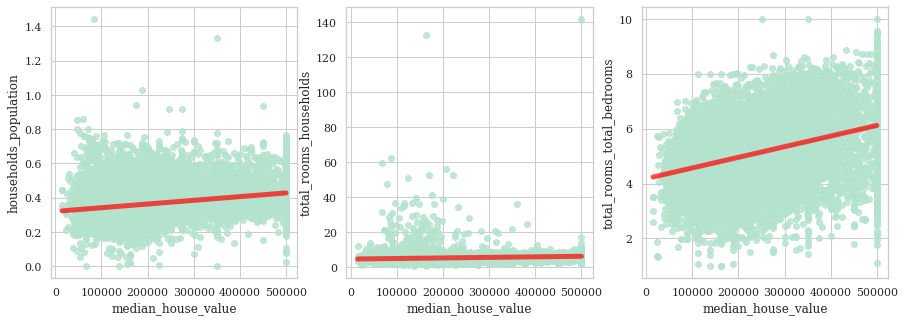

In [66]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.regplot(x=train_dataset["median_house_value"], y=train_dataset["households_population"], line_kws={"color":"r","alpha":0.7,"lw":5}, ax=axs[0])
sns.regplot(x=train_dataset["median_house_value"], y=train_dataset["total_rooms_households"], line_kws={"color":"r","alpha":0.7,"lw":5}, ax=axs[1])
sns.regplot(x=train_dataset["median_house_value"], y=train_dataset["total_rooms_total_bedrooms"], line_kws={"color":"r","alpha":0.7,"lw":5}, ax=axs[2])

### Feature creation

Wie bei der Analyse der geographischen Daten festgestellt, kann es sinnvoll sein diese im statistischen Modell zu berücksichtigen. Es hat sich gezeigt, dass in bestimmten geographischen Bereichen verstärkt Distrikte mit hohem *median_house_value* liegen. Um Koordinatenangaben in Bereiche zu gliedern, können verschiedene Verfahren angewendet werden, z.B. Clustering. Ein anderer Ansatz ist die Verwendung von geohashes mit der Python-Bibliothek geohash. Im zu Grunde liegenden Konzept werden GPS-Daten in eine Kombination aus Buchstaben und Ziffern kodiert. Die Erde wird dabei in ein Schema aus Rechtecken unterteilt. Die Größe des Gitters wird über die Anzahl der Buchstaben bestimmt.[Quelle: [Wikpedia](https://en.wikipedia.org/wiki/Geohash)]

<img src="doc\geohash_grid.JPG" width="400"/>

In [67]:
import geohash as gh
train_dataset_geo = train_dataset[['latitude', 'longitude']]
train_dataset['geohash']=train_dataset_geo.apply(lambda x: gh.encode(x.latitude, x.longitude, precision=3), axis=1)
train_dataset['geohash'] = train_dataset['geohash'].astype("category")

train_dataset

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
14740    -117.05     32.58                22.0         2101           399.0   
10101    -117.97     33.92                32.0         2620           398.0   
20566    -121.84     38.65                29.0         3167           548.0   
2670     -115.60     33.20                37.0          709           187.0   
15709    -122.43     37.79                25.0         1637           394.0   
...          ...       ...                 ...          ...             ...   
7616     -118.22     33.86                16.0         8732          1489.0   
8767     -118.39     33.81                35.0         1008           165.0   
16388    -121.30     38.05                52.0          122            26.0   
19949    -119.37     36.21                35.0         2228           476.0   
10078    -120.27     39.35                11.0         2520           401.0   

       population  households  median_income  median_house_value  \
14740        1551         371         4.1518            136900.0   
10101        1296         429         5.7796            241300.0   
20566        1554         534         4.3487            200700.0   
2670          390         142         2.4511             72500.0   
15709         649         379         5.0049            460000.0   
...           ...         ...            ...                 ...   
7616         3944        1493         5.1948            203500.0   
8767          391         167         3.7778            487500.0   
16388          62          25         1.1500            112500.0   
19949        1567         449         1.4455             54100.0   
10078         397         165         4.6650            145600.0   

      ocean_proximity price_category  households_population  \
14740      NEAR OCEAN          below               0.239201   
10101       <1H OCEAN          above               0.331019   
20566          INLAND          above               0.343629   
2670           INLAND          below               0.364103   
15709        NEAR BAY          above               0.583975   
...               ...            ...                    ...   
7616        <1H OCEAN          above               0.378550   
8767       NEAR OCEAN          above               0.427110   
16388          INLAND          below               0.403226   
19949          INLAND          below               0.286535   
10078          INLAND          below               0.415617   

       total_rooms_households  total_rooms_total_bedrooms geohash  
14740                5.663073                    5.265664     9mu  
10101                6.107226                    6.582915     9qh  
20566                5.930712                    5.779197     9qc  
2670                 4.992958                    3.791444     9mv  
15709                4.319261                    4.154822     9q8  
...                       ...                         ...     ...  
7616                 5.848627                    5.864338     9q5  
8767                 6.035928                    6.109091     9q5  
16388                4.880000                    4.692308     9qc  
19949                4.962138                    4.680672     9q7  
10078               15.272727                    6.284289     9qf  

[16351 rows x 15 columns]

In [68]:
train_dataset['geohash'].describe(include=['category'])

count     16351
unique       32
top         9q5
freq       3832
Name: geohash, dtype: object

Die Größe der Gitter ist auf drei Stellen des geohashs auslegt. Dies entspricht einem Gitter von einer Länge und Höhe von 156 km. Das neue Feature "geohash" hat eine Ausprägung von 32 Werten. Mit einer vierstelligen Auflösung wäre es 493 Werte. Damit würde das Risiko für overfitting erhöht und die Anzahl der Spalten bei der Bildung von Dummy-Variablen aufgebläht werden. 
Da es sich um eine künstlich erzeugte kategoriale Variable handelt, besteht ebenfalls das Risiko, dass in den Testdaten Ausprägungen vorkommen mit welchen das Modell nicht trainiert wurde. 

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

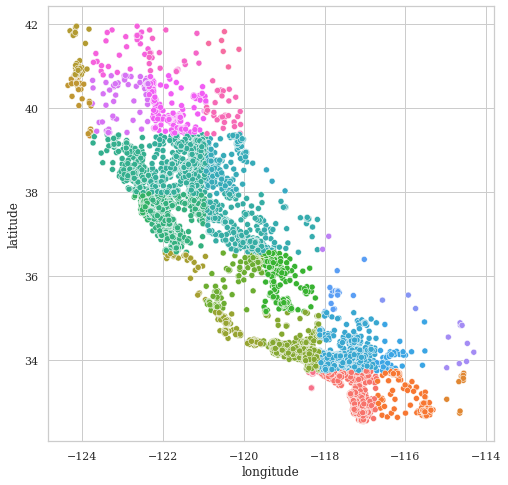

In [69]:
sns.scatterplot(data=train_dataset, x="longitude", y="latitude", hue="geohash", legend= False)


> Weiter Feature Selection findet modellspezifisch im nächsten Schritt statt. 